In [ ]:
import math
import os
import numpy as np
from typing import Dict, Tuple, Optional, List

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.neighbors import NearestNeighbors

In [ ]:
def read_fvecs(path: str) -> np.ndarray:
    a = np.fromfile(path, dtype='int32')
    if a.size == 0:
        raise ValueError(f"Empty fvecs file at {path}")
    d = a[0]
    return a.reshape(-1, d + 1)[:, 1:].astype('float32')


def read_ivecs(path: str) -> np.ndarray:
    a = np.fromfile(path, dtype='int32')
    if a.size == 0:
        raise ValueError(f"Empty ivecs file at {path}")
    d = a[0]
    return a.reshape(-1, d + 1)[:, 1:]


def load_sift_dataset(root: str = "./sift") -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    base_path = os.path.join(root, "sift_base.fvecs")
    query_path = os.path.join(root, "sift_query.fvecs")
    gt_path = os.path.join(root, "sift_groundtruth.ivecs")

    X = read_fvecs(base_path)           # (N, d)
    Q = read_fvecs(query_path)         # (nq, d)
    GT = read_ivecs(gt_path)           # (nq, k_gt)

    print(f"Loaded SIFT base: {X.shape}, queries: {Q.shape}, GT: {GT.shape}")
    return X, Q, GT

In [ ]:
def build_knn_graph(
    X: np.ndarray,
    k: int = 10,
    metric: str = "euclidean",
    symmetrize: bool = True,
) -> torch.LongTensor:
    n, d = X.shape
    print(f"Building k-NN graph with n={n}, d={d}, k={k} ...")

    nbrs = NearestNeighbors(n_neighbors=k + 1, metric=metric)  # +1 to include self
    nbrs.fit(X)
    distances, indices = nbrs.kneighbors(X)

    rows = []
    cols = []
    for i in range(n):
        for idx in indices[i]:
            if idx == i:
                continue
            rows.append(i)
            cols.append(idx)

    edges = np.stack([rows, cols], axis=1)

    if symmetrize:
        rev = edges[:, [1, 0]]
        edges = np.concatenate([edges, rev], axis=0)
        edges = np.unique(edges, axis=0)

    edge_index = torch.from_numpy(edges).long()
    print(f"k-NN graph has {edge_index.shape[0]} edges.")
    return edge_index


In [ ]:
class MLPPartitioner(nn.Module):
    def __init__(
        self,
        input_dim: int,
        num_bins: int,
        hidden_dims=(256, 256),
        dropout: float = 0.0,
        temperature: float = 1.0,   # NEW: softmax temperature
    ):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            if dropout > 0.0:
                layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, num_bins))
        self.net = nn.Sequential(*layers)
        self.temperature = temperature

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        logits = self.net(x)
        # Temperature > 1 => softer; < 1 => sharper
        logits = logits / self.temperature
        return F.softmax(logits, dim=-1)

In [ ]:
def cut_loss(assignments: torch.Tensor, edge_index: torch.LongTensor) -> torch.Tensor:
    """
    Soft graph cut: L_cut = avg_{(i,j)} [1 - sum_c a_{i,c} a_{j,c}]
    """
    i = edge_index[:, 0]
    j = edge_index[:, 1]
    a_i = assignments[i]
    a_j = assignments[j]
    same_prob = (a_i * a_j).sum(dim=-1)
    return (1.0 - same_prob).mean()


def balance_loss(assignments: torch.Tensor) -> torch.Tensor:
    """
    L_bal = mean_c ( (s_c / N - 1/m)^2 )
    """
    N, m = assignments.shape
    s = assignments.sum(dim=0) / N  # fraction of mass in each bin
    target = 1.0 / m
    return ((s - target) ** 2).mean()


def smoothness_loss(assignments: torch.Tensor, edge_index: torch.LongTensor) -> torch.Tensor:
    """
    L_smooth ~= avg_{(i,j)} ||a_i - a_j||^2
    """
    i = edge_index[:, 0]
    j = edge_index[:, 1]
    a_i = assignments[i]
    a_j = assignments[j]
    return ((a_i - a_j) ** 2).sum(dim=-1).mean()

import math

def entropy_loss(assignments: torch.Tensor) -> torch.Tensor:
    """
    Encourage high entropy per point (avoid peaky one-hot assignments).
    Return a loss in [0, 1], where 0 = max entropy, 1 = zero entropy.
    """

    m = assignments.shape[1]

    log_p = (assignments + 1e-12).log()
    ent = - (assignments * log_p).sum(dim=-1).mean()

    ent_norm = ent / math.log(m)

    return 1.0 - ent_norm



def distillation_loss(assignments: torch.Tensor, teacher_labels: torch.LongTensor) -> torch.Tensor:
    """
    Optional: distill from a discrete partition (e.g., KaHIP).
    teacher_labels: (N,)
    """
    return F.cross_entropy(assignments.log(), teacher_labels)

In [ ]:
def train_joint_partitioner(
    X: np.ndarray,
    num_bins: int,
    edge_index: torch.LongTensor,
    teacher_labels: Optional[np.ndarray] = None,
    hidden_dims=(256, 256),
    dropout: float = 0.0,
    device: str = "cuda" if torch.cuda.is_available() else "cpu",
    lr: float = 1e-3,
    weight_cut: float = 1.0,
    weight_bal: float = 200.0,
    weight_smooth: float = 0.1,
    weight_distill: float = 0.0,
    weight_entropy: float = 0.5,
    num_epochs: int = 50,
    print_every: int = 5,
    temperature: float = 1.5,      e
) -> Tuple[MLPPartitioner, dict]:
    X_t = torch.from_numpy(X).float().to(device)
    edge_index = edge_index.to(device)
    N, d = X_t.shape

    if teacher_labels is not None:
        teacher_labels_t = torch.from_numpy(teacher_labels).long().to(device)
    else:
        teacher_labels_t = None

    model = MLPPartitioner(
        input_dim=d,
        num_bins=num_bins,
        hidden_dims=hidden_dims,
        dropout=dropout,
        temperature=temperature,
    ).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=lr)

    history = {
        "total": [],
        "cut": [],
        "bal": [],
        "smooth": [],
        "distill": [],
        "entropy": [],
    }

    for epoch in range(1, num_epochs + 1):
        model.train()
        opt.zero_grad()

        assignments = model(X_t)  # (N, m)

        l_cut = cut_loss(assignments, edge_index)
        l_bal = balance_loss(assignments)
        l_smooth = (
            smoothness_loss(assignments, edge_index)
            if weight_smooth > 0.0
            else torch.tensor(0.0, device=device)
        )
        l_distill = (
            distillation_loss(assignments, teacher_labels_t)
            if (teacher_labels_t is not None and weight_distill > 0.0)
            else torch.tensor(0.0, device=device)
        )
        l_ent = (
            entropy_loss(assignments)
            if weight_entropy > 0.0
            else torch.tensor(0.0, device=device)
        )

        total = (
            weight_cut * l_cut
            + weight_bal * l_bal
            + weight_smooth * l_smooth
            + weight_distill * l_distill
            + weight_entropy * l_ent
        )

        total.backward()
        opt.step()

        history["total"].append(total.item())
        history["cut"].append(l_cut.item())
        history["bal"].append(l_bal.item())
        history["smooth"].append(l_smooth.item())
        history["distill"].append(l_distill.item())
        history["entropy"].append(l_ent.item())

        if epoch == 1 or epoch % print_every == 0:
            with torch.no_grad():
                bin_mass = assignments.mean(dim=0).detach().cpu().numpy()
            print(
                f"[Epoch {epoch:03d}] "
                f"total={total.item():.4f} "
                f"cut={l_cut.item():.4f} "
                f"bal={l_bal.item():.4f} "
                f"smooth={l_smooth.item():.4f} "
                f"distill={l_distill.item():.4f} "
                f"ent={l_ent.item():.4f}"
            )

            print("   first 10 bin masses:", np.round(bin_mass[:10], 4))
            print("   max bin mass:", float(bin_mass.max()))

    return model, history


SyntaxError: parameter without a default follows parameter with a default (ipython-input-1864772881.py, line 17)

In [ ]:
def assign_bins(
    model: MLPPartitioner,
    X: np.ndarray,
    device: str = "cuda" if torch.cuda.is_available() else "cpu",
) -> Tuple[np.ndarray, np.ndarray]:
    model.eval()
    X_t = torch.from_numpy(X).float().to(device)
    with torch.no_grad():
        a = model(X_t).cpu().numpy()
    hard_bins = a.argmax(axis=1)
    return hard_bins, a


def build_bin_index(hard_bins: np.ndarray) -> Dict[int, np.ndarray]:
    bin_map: Dict[int, List[int]] = {}
    for i, b in enumerate(hard_bins):
        bin_map.setdefault(int(b), []).append(i)
    return {b: np.array(idxs, dtype=np.int64) for b, idxs in bin_map.items()}


def multiprobe_candidates(
    model: MLPPartitioner,
    q: np.ndarray,
    bin_index: Dict[int, np.ndarray],
    num_bins_to_probe: int,
    device: str = "cuda" if torch.cuda.is_available() else "cpu",
) -> np.ndarray:
    model.eval()
    q_t = torch.from_numpy(q[None, :]).float().to(device)
    with torch.no_grad():
        a_q = model(q_t).cpu().numpy()[0]  # (m,)
    sorted_bins = np.argsort(-a_q)
    chosen = sorted_bins[:num_bins_to_probe]
    candidates = []
    for b in chosen:
        if b in bin_index:
            candidates.extend(bin_index[b].tolist())
    return np.array(candidates, dtype=np.int64)




def l2_dist(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    """
    Compute squared L2 distances between a single vector a (d,) and matrix b (n, d).
    """
    diff = b - a[None, :]
    return np.sum(diff * diff, axis=1)

In [ ]:
def evaluate_recall_sift(
    X: np.ndarray,
    Q: np.ndarray,
    GT: np.ndarray,
    model: MLPPartitioner,
    bin_index: Dict[int, np.ndarray],
    num_bins_to_probe_list: List[int],
    topk: int = 10,
    max_queries: int = 1000,
) -> None:
    nq = min(len(Q), max_queries)
    print(f"Evaluating on {nq} queries...")

    results = {}
    for nb in num_bins_to_probe_list:
        recalls = []
        cand_counts = []
        for qi in range(nq):
            q = Q[qi]
            gt = GT[qi, :topk]
            cand_idx = multiprobe_candidates(model, q, bin_index, nb)
            cand_counts.append(len(cand_idx))


            if len(cand_idx) == 0:
                recalls.append(0.0)
                continue

            dists = l2_dist(q, X[cand_idx])
            topk_idx_local = np.argsort(dists)[:topk]
            retrieved = cand_idx[topk_idx_local]


            inter = np.intersect1d(retrieved, gt)
            recalls.append(len(inter) / float(topk))

        recalls = np.array(recalls)
        cand_counts = np.array(cand_counts)

        results[nb] = {
            "recall_mean": float(recalls.mean()),
            "cand_mean": float(cand_counts.mean()),
            "cand_p95": float(np.percentile(cand_counts, 95)),
        }

    print("===== Recall@{} vs candidates =====".format(topk))
    for nb in num_bins_to_probe_list:
        r = results[nb]
        print(f"Bins={nb:3d} | recall={r['recall_mean']:.4f} "
              f"| avg_cands={r['cand_mean']:.1f} | p95_cands={r['cand_p95']:.1f}")




if __name__ == "__main__":
    #load SIFT
    X, Q, GT = load_sift_dataset("./sift")

    #change later, just for testing
    N_base = 200_000
    N_query = 2000
    rng = np.random.default_rng(0)
    base_indices = rng.choice(len(X), size=N_base, replace=False)
    X_sub = X[base_indices]


    Q_sub = Q[:N_query]

    print("Recomputing ground truth NN for subset (dev mode)...")
    nbrs_gt = NearestNeighbors(n_neighbors=100, metric="euclidean")
    nbrs_gt.fit(X_sub)
    _, gt_idx = nbrs_gt.kneighbors(Q_sub)
    GT_sub = gt_idx.astype(np.int32)

    # build k-NN graph on X_sub
    edge_index = build_knn_graph(X_sub, k=10, metric="euclidean")

    #train joint partitioner
    num_bins = 32
    model, hist = train_joint_partitioner(
      X_sub,
      num_bins=num_bins,
      edge_index=edge_index,
      teacher_labels=None,
      hidden_dims=(256, 256),
      dropout=0.1,
      lr=1e-3,
      weight_cut=1.0,
      weight_bal=200.0,
      weight_smooth=0.1,
      weight_distill=0.0,
      weight_entropy=0.5,
      num_epochs=50,
      print_every=5,
      temperature=1.5,
  )

    #assign bins and build index
    hard_bins, _ = assign_bins(model, X_sub)
    bin_index = build_bin_index(hard_bins)

    # evaluate recall@10 vs #bins probed
    num_bins_to_probe_list = [1, 2, 4, 8, 16, 32, 64]
    evaluate_recall_sift(
        X_sub,
        Q_sub,
        GT_sub,
        model,
        bin_index,
        num_bins_to_probe_list,
        topk=10,
        max_queries=N_query,
    )


FileNotFoundError: [Errno 2] No such file or directory: './sift/sift_base.fvecs'

# 2nd Experiment

In [ ]:
import math
import random
from typing import Dict, Any, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
class PartitionNet(nn.Module):
    """
    Small MLP that maps R^d -> {0,...,m-1} via logits.
    """
    def __init__(self, dim_in: int, num_bins: int,
                 hidden_sizes=(512, 512), dropout=0.1):
        super().__init__()
        layers = []
        last = dim_in
        for hs in hidden_sizes:
            layers.append(nn.Linear(last, hs))
            layers.append(nn.BatchNorm1d(hs))
            layers.append(nn.ReLU(inplace=True))
            if dropout > 0:
                layers.append(nn.Dropout(p=dropout))
            last = hs
        self.backbone = nn.Sequential(*layers)
        self.head = nn.Linear(last, num_bins)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = self.backbone(x)
        logits = self.head(h)
        return logits

In [ ]:
def train_classifier(
    model: nn.Module,
    X: torch.Tensor,
    labels: np.ndarray,
    num_epochs: int = 5,
    batch_size: int = 4096,
    lr: float = 1e-3,
    weight_decay: float = 1e-4,
    device: str = "cuda"
) -> None:
    """
    Train classifier on current hard labels.
    """
    model.to(device)
    model.train()

    y = torch.from_numpy(labels.astype(np.int64))
    if X.device != device:
        X = X.to(device)
    y = y.to(device)

    ds = TensorDataset(X, y)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=False)

    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(num_epochs):
        running_loss = 0.0
        n_batches = 0
        for xb, yb in loader:
            opt.zero_grad()
            logits = model(xb)
            loss = F.cross_entropy(logits, yb)
            loss.backward()
            opt.step()

            running_loss += loss.item()
            n_batches += 1

        avg_loss = running_loss / max(1, n_batches)
        print(f"[train_classifier] epoch {epoch+1}/{num_epochs} loss={avg_loss:.4f}")

In [ ]:
def refine_partition(
    labels: np.ndarray,
    pred_probs: np.ndarray,
    knn_idx: np.ndarray,
    num_bins: int,
    balance_slack: float = 0.1,
    margin_thresh: float = 0.2,
    neighbor_gain_thresh: int = 1,
    max_moves_per_iter: int = 100_000,
    random_seed: int = 123
) -> Tuple[np.ndarray, Dict[str, Any]]:
    """
    One refinement step: move a subset of points to the bin that the classifier
    strongly prefers IF this also improves neighbor consistency and respects balance.

    Args:
        labels: (n,) current bin labels [0..m-1]
        pred_probs: (n, m) classifier softmax probabilities
        knn_idx: (n, k) indices of kNN graph (no particular symmetry assumed)
        num_bins: number of bins m
        balance_slack: allowed fractional deviation from perfect balance
                       (bin sizes in [(1 - s)*n/m, (1 + s)*n/m])
        margin_thresh: required P(new_bin) - P(old_bin) to consider a move
        neighbor_gain_thresh: required increase in "# neighbors in same bin" to accept move
        max_moves_per_iter: hard cap on moves per refinement iteration
        random_seed: for reproducibility of iteration order

    Returns:
        new_labels: updated labels
        stats: dict of diagnostics
    """
    n = labels.shape[0]
    k = knn_idx.shape[1]

    # Current bin sizes
    sizes = np.bincount(labels, minlength=num_bins).astype(np.int64)
    target = n / float(num_bins)
    min_size = int((1.0 - balance_slack) * target)
    max_size = int((1.0 + balance_slack) * target)

    # Basic sanity
    assert pred_probs.shape == (n, num_bins)
    assert knn_idx.shape[0] == n

    # Argmax & margins
    pred_labels = pred_probs.argmax(axis=1)
    pred_conf = pred_probs.max(axis=1)
    old_conf = pred_probs[np.arange(n), labels]
    margins = pred_conf - old_conf

    # Precompute neighbor labels for quick local counts
    neighbor_labels = labels[knn_idx]  # shape (n, k)

    # Candidate points: classifier disagrees & confident margin
    candidates = np.where(
        (pred_labels != labels) & (margins >= margin_thresh)
    )[0]

    print(f"[refine_partition] {len(candidates)} candidates before filtering")

    # Shuffle candidates for fairness / stochasticity
    rng = np.random.RandomState(random_seed)
    rng.shuffle(candidates)

    moves = 0
    improved_pairs = 0
    worsened_pairs = 0

    new_labels = labels.copy()

    for idx in candidates:
        if moves >= max_moves_per_iter:
            break

        cur_bin = new_labels[idx]
        new_bin = pred_labels[idx]

        if cur_bin == new_bin:
            continue

        # Balance constraints
        if sizes[cur_bin] <= min_size:
            continue
        if sizes[new_bin] >= max_size:
            continue

        # Local neighbor agreement
        nbr_lbls = new_labels[knn_idx[idx]]   # (k,)
        same_old = np.sum(nbr_lbls == cur_bin)
        same_new = np.sum(nbr_lbls == new_bin)
        gain = int(same_new - same_old)

        if gain < neighbor_gain_thresh:
            continue  # not worth moving

        # Accept move
        new_labels[idx] = new_bin
        sizes[cur_bin] -= 1
        sizes[new_bin] += 1
        moves += 1

        if gain > 0:
            improved_pairs += gain
        elif gain < 0:
            worsened_pairs -= gain  # positive count

    stats = {
        "num_moves": moves,
        "improved_neighbor_pairs": improved_pairs,
        "worsened_neighbor_pairs": worsened_pairs,
        "final_sizes": sizes,
    }

    print(
        f"[refine_partition] moves={moves}, "
        f"improved_pairs={improved_pairs}, worsened_pairs={worsened_pairs}"
    )
    print(
        "[refine_partition] bin size stats: "
        f"min={sizes.min()}, max={sizes.max()}, mean={sizes.mean():.1f}, "
        f"target={target:.1f}"
    )

    return new_labels, stats

In [ ]:
def alternating_refinement(
    X_np: np.ndarray,
    knn_idx: np.ndarray,
    labels_init: np.ndarray,
    num_bins: int,
    num_outer_iters: int = 5,
    clf_epochs: int = 5,
    clf_batch_size: int = 4096,
    clf_lr: float = 1e-3,
    clf_weight_decay: float = 1e-4,
    balance_slack: float = 0.1,
    margin_thresh: float = 0.2,
    neighbor_gain_thresh: int = 1,
    max_moves_per_iter: int = 100_000,
    device: str = "cuda",
    random_seed: int = 123
) -> Tuple[PartitionNet, np.ndarray]:
    """
    Top-level alternating optimization:
        (1) train classifier on current labels
        (2) run refinement that updates labels using classifier + kNN graph.

    Args:
        X_np: (n, d) float32 numpy array of base vectors
        knn_idx: (n, k) int numpy array of neighbors
        labels_init: (n,) int numpy array of initial labels [0..m-1]
        num_bins: number of bins
        num_outer_iters: number of outer alternating rounds
        clf_*: classifier training hyperparameters
        balance_slack, margin_thresh, neighbor_gain_thresh, max_moves_per_iter:
            refinement hyperparameters
        device: "cuda" or "cpu"
        random_seed: for reproducibility

    Returns:
        model: trained PartitionNet
        labels: final refined labels
    """
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)

    n, d = X_np.shape
    labels = labels_init.copy().astype(np.int64)

    # Create torch tensor once and reuse
    X = torch.from_numpy(X_np.astype(np.float32))

    # Initialize model
    model = PartitionNet(dim_in=d, num_bins=num_bins, hidden_sizes=(512, 512), dropout=0.1)

    for it in range(num_outer_iters):
        print("=" * 80)
        print(f"[alternating_refinement] Outer iteration {it+1}/{num_outer_iters}")

        # 1) Train classifier on current labels
        train_classifier(
            model,
            X,
            labels,
            num_epochs=clf_epochs,
            batch_size=clf_batch_size,
            lr=clf_lr,
            weight_decay=clf_weight_decay,
            device=device,
        )

        # 2) Get classifier probabilities on all points
        model.eval()
        with torch.no_grad():
            logits = []
            bs_eval = 8192
            X_device = X.to(device)
            for i in range(0, n, bs_eval):
                xb = X_device[i:i+bs_eval]
                lb = model(xb)
                logits.append(lb.cpu())
            logits = torch.cat(logits, dim=0)
            probs = F.softmax(logits, dim=1).numpy()

        # 3) Refine partition using predictions + kNN graph
        labels, stats = refine_partition(
            labels=labels,
            pred_probs=probs,
            knn_idx=knn_idx,
            num_bins=num_bins,
            balance_slack=balance_slack,
            margin_thresh=margin_thresh,
            neighbor_gain_thresh=neighbor_gain_thresh,
            max_moves_per_iter=max_moves_per_iter,
            random_seed=random_seed + it,  # vary order slightly per iter
        )

        print(f"[alternating_refinement] Done iter {it+1}, stats: {stats}")

    return model, labels

In [ ]:
import os
import numpy as np

DATA_DIR = "sift"  # created by your tar extraction

def read_fvecs(fname: str) -> np.ndarray:
    """
    Read *.fvecs from TexMex / Faiss format.
    Each vector: [int32 d][d x float32].
    Returns float32 array of shape (n, d).
    """
    a = np.fromfile(fname, dtype='int32')
    if a.size == 0:
        raise IOError(f"File {fname} is empty or not found")
    d = a[0]
    assert (a.size % (d + 1)) == 0, "fvecs file malformed"
    a = a.reshape(-1, d + 1)
    return a[:, 1:].view('float32')

def read_ivecs(fname: str) -> np.ndarray:
    """
    Read *.ivecs from TexMex / Faiss format
    (same layout but last d entries are int32).
    Returns int32 array of shape (n, d).
    """
    a = np.fromfile(fname, dtype='int32')
    if a.size == 0:
        raise IOError(f"File {fname} is empty or not found")
    d = a[0]
    assert (a.size % (d + 1)) == 0, "ivecs file malformed"
    a = a.reshape(-1, d + 1)
    return a[:, 1:].copy()

# Load base, queries, ground truth
X_base  = read_fvecs(os.path.join(DATA_DIR, "sift_base.fvecs"))   # (1e6, 128)
X_query = read_fvecs(os.path.join(DATA_DIR, "sift_query.fvecs"))  # (1e4, 128)
gt_ivecs = read_ivecs(os.path.join(DATA_DIR, "sift_groundtruth.ivecs"))  # (1e4, 100)

print("X_base:",  X_base.shape, X_base.dtype)
print("X_query:", X_query.shape, X_query.dtype)
print("groundtruth:", gt_ivecs.shape, gt_ivecs.dtype)

X_base: (1000000, 128) float32
X_query: (10000, 128) float32
groundtruth: (10000, 100) int32


In [ ]:
!pip install -q faiss-cpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 68.6 MB/s eta 0:00:00


In [ ]:
import faiss
import numpy as np

# Ensure contiguous float32
Xb = np.ascontiguousarray(X_base.astype('float32'))
n, d = Xb.shape
print("Base vectors:", n, d)

# Build HNSW index (you can tweak these hyperparams)
M = 32
index = faiss.IndexHNSWFlat(d, M)
index.hnsw.efConstruction = 200
index.verbose = True

index.add(Xb)
print("Index n_total:", index.ntotal)

# Compute k-NN for all base points (include self, drop later)
k_graph = 10  # number of neighbors for graph partition (paper uses 16–50)
distances, neighbors = index.search(Xb, k_graph + 1)  # +1 because self is included

# Drop self (neighbors[:, 0] == i)
knn_idx = neighbors[:, 1:]  # shape (n, k_graph), int64

print("knn_idx shape:", knn_idx.shape, knn_idx.dtype)


Base vectors: 1000000 128
Index n_total: 1000000
knn_idx shape: (1000000, 10) int64


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def write_knn_metis(
    knn_idx: np.ndarray,
    out_path: str
) -> None:
    """
    Write k-NN graph to METIS format.
    We symmetrize the k-NN edges and remove duplicates.
    """
    n, k = knn_idx.shape
    print(f"Writing METIS graph for n={n}, k={k} to {out_path}")

    # Build undirected adjacency (0-based indices in Python)
    adj = [set() for _ in range(n)]
    for i in range(n):
        for j in knn_idx[i]:
            if j == i:
                continue
            adj[i].add(int(j))
            adj[j].add(int(i))

    # Number of undirected edges (METIS wants this)
    m = sum(len(neighs) for neighs in adj) // 2
    print(f"Total undirected edges m={m}")

    with open(out_path, "w") as f:
        # Header: n m
        f.write(f"{n} {m}\n")
        # Each row: adjacency list for node i (1-based indices)
        for i in range(n):
            # Sort neighbors for determinism, convert to 1-based
            neighs = sorted(list(adj[i]))
            if neighs:
                line = " ".join(str(j + 1) for j in neighs)
            else:
                line = ""  # isolated node
            f.write(line + "\n")

    print("Done writing METIS graph.")

# Actually write the graph
#os.makedirs("graphs", exist_ok=True)
graph_path = "/content/drive/MyDrive/Neural_LSH/sift_knn_k16.metis"
write_knn_metis(knn_idx, graph_path)

Writing METIS graph for n=1000000, k=10 to /content/drive/MyDrive/Neural_LSH/sift_knn_k16.metis
Total undirected edges m=8038280
Done writing METIS graph.


In [ ]:
!pip install kahip


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 62.2 MB/s eta 0:00:00


In [ ]:
import numpy as np

def knn_to_csr(knn_idx: np.ndarray):
    """
    Convert a (n, k) knn index matrix into an undirected CSR graph for KaHIP.

    Returns:
        vwgt   : list[int] node weights (all 1)
        xadj   : list[int] CSR row pointer, length n+1
        adjcwgt: list[int] edge weights (all 1)
        adjncy : list[int] column indices (neighbors)
    """
    n, k = knn_idx.shape
    print(f"Building CSR from k-NN graph: n={n}, k={k}")

    # 1) Build adjacency sets to avoid duplicate edges
    adj = [set() for _ in range(n)]
    for i in range(n):
        for j in knn_idx[i]:
            j = int(j)
            if j == i:
                continue
            adj[i].add(j)
            adj[j].add(i)

    # 2) Flatten into CSR
    xadj = [0]
    adjncy = []
    adjcwgt = []

    for i in range(n):
        neighs = sorted(adj[i])  # deterministic
        adjncy.extend(neighs)
        adjcwgt.extend([1] * len(neighs))
        xadj.append(len(adjncy))

    vwgt = [1] * n  # all nodes same weight

    print(f"CSR: |V|={n}, |E|≈{len(adjncy)//2} undirected edges")
    return vwgt, xadj, adjcwgt, adjncy

vwgt, xadj, adjcwgt, adjncy = knn_to_csr(knn_idx)


Building CSR from k-NN graph: n=1000000, k=10
CSR: |V|=1000000, |E|≈8038280 undirected edges


In [ ]:
import kahip

# number of blocks (bins) you want – this is your m
num_bins = 256      # or whatever you used in the Neural LSH setup
imbalance = 0.03    # 3% imbalance (tweak if you want tighter balance)
supress_output = 0  # 0 = show; 1 = silence
seed = 0

# KaHIP modes (from README):
# 0=FAST, 1=ECO, 2=STRONG, 3=FASTSOCIAL, 4=ECOSOCIAL, 5=STRONGSOCIAL :contentReference[oaicite:1]{index=1}
# Neural-LSH-style "social network" config → e.g. FASTSOCIAL or ECOSOCIAL
mode = 3  # FASTSOCIAL; try 4 (ECOSOCIAL) for more quality, more time

edgecut, blocks = kahip.kaffpa(
    vwgt, xadj, adjcwgt, adjncy,
    num_bins,
    imbalance,
    supress_output,
    seed,
    mode,
)

print("KaHIP edge cut:", edgecut)
labels_kahip = np.array(blocks, dtype=np.int64)
print("labels_kahip shape:", labels_kahip.shape)
print("num_bins (from labels):", int(labels_kahip.max() + 1))


KaHIP edge cut: 3376177
labels_kahip shape: (1000000,)
num_bins (from labels): 256


In [ ]:
model, labels_refined = alternating_refinement(
    X_np=X_base,              # SIFT base vectors, shape (n, 128)
    knn_idx=knn_idx,          # same k-NN index matrix you used for CSR
    labels_init=labels_kahip, # KaHIP initial partition
    num_bins=int(labels_kahip.max() + 1),
    num_outer_iters=3,
    clf_epochs=3,
    clf_batch_size=4096,
    clf_lr=1e-3,
    clf_weight_decay=1e-4,
    balance_slack=0.1,
    margin_thresh=0.2,
    neighbor_gain_thresh=1,
    max_moves_per_iter=50_000,
    device="cuda" if torch.cuda.is_available() else "cpu",
    random_seed=123,
)

print("Refined label distribution (first few bins):")
print(np.bincount(labels_refined)[:10])


[alternating_refinement] Outer iteration 1/3
[train_classifier] epoch 1/3 loss=1.8614
[train_classifier] epoch 2/3 loss=1.4063
[train_classifier] epoch 3/3 loss=1.3363
[refine_partition] 235400 candidates before filtering
[refine_partition] moves=23789, improved_pairs=51250, worsened_pairs=0
[refine_partition] bin size stats: min=349, max=4296, mean=3906.2, target=3906.2
[alternating_refinement] Done iter 1, stats: {'num_moves': 23789, 'improved_neighbor_pairs': 51250, 'worsened_neighbor_pairs': 0, 'final_sizes': array([4047, 4040, 4002, 4054, 3955, 3323, 4086, 4004, 4042, 4049, 3983,
       3908, 4019, 3991, 3975, 4054, 4064, 4028, 4296, 4029, 4095, 4044,
       4032, 4067, 4047, 1578, 4011, 3945, 3900, 4111, 3964, 3924, 3995,
       4023, 4110, 3572, 4049, 4096, 3964, 4064, 3995, 3945, 4059, 3940,
       3914, 4117, 4049, 3494, 3960, 3903, 4035, 3996, 4041, 3985, 4052,
       4064, 4031, 3941, 3990, 3148, 3967, 4097, 3074, 1634, 4091, 4132,
       4006, 4095, 3992, 4127, 3950, 3954, 

In [ ]:
import matplotlib.pyplot as plt

def compute_recall_candidates_curve(
    model: nn.Module,
    X_base: np.ndarray,
    X_query: np.ndarray,
    gt_ivecs: np.ndarray,
    labels: np.ndarray,
    num_bins: int,
    bins_to_probe_list,
    k_eval: int = 10,
    device: str = "cuda"
):
    """
    For each #bins_to_probe, compute:
      - avg candidate count
      - 0.95-quantile candidate count
      - avg k-NN recall (fraction of top-k ground truth inside candidates)
    """
    model.to(device)
    model.eval()

    n, d = X_base.shape
    nq = X_query.shape[0]

    # precompute bin members as numpy arrays
    bin_members = [np.where(labels == b)[0] for b in range(num_bins)]
    bin_sizes = np.array([len(bm) for bm in bin_members])
    print("Bin sizes: min =", bin_sizes.min(), "max =", bin_sizes.max(), "mean =", bin_sizes.mean())

    # forward queries through classifier
    Xq_t = torch.from_numpy(X_query.astype(np.float32)).to(device)
    logits_q = []
    bs = 1024
    with torch.no_grad():
        for i in range(0, nq, bs):
            xb = Xq_t[i:i+bs]
            lb = model(xb)
            logits_q.append(lb.cpu())
    logits_q = torch.cat(logits_q, dim=0)  # (nq, m)
    probs_q = F.softmax(logits_q, dim=1).numpy()

    # sort bins for each query by descending probability
    top_bins_all = np.argsort(-probs_q, axis=1)  # (nq, m)

    results = {
        "bins_to_probe": [],
        "avg_candidates": [],
        "q95_candidates": [],
        "avg_recall": [],
    }

    for T in bins_to_probe_list:
        T = int(T)
        assert T > 0 and T <= num_bins

        cand_counts = []
        recalls = []

        for qi in range(nq):
            # bins to query
            bins_q = top_bins_all[qi, :T]
            # concatenate bin members
            cand_idx = np.concatenate([bin_members[b] for b in bins_q])
            # unique (for safety; overlap shouldn't happen)
            cand_idx = np.unique(cand_idx)

            cand_counts.append(len(cand_idx))

            # ground truth top-k
            gt = gt_ivecs[qi, :k_eval]
            # recall: how many gt in candidate set
            hit = np.intersect1d(gt, cand_idx, assume_unique=False).size
            recalls.append(hit / float(k_eval))

        cand_counts = np.array(cand_counts)
        recalls = np.array(recalls)

        results["bins_to_probe"].append(T)
        results["avg_candidates"].append(cand_counts.mean())
        results["q95_candidates"].append(np.quantile(cand_counts, 0.95))
        results["avg_recall"].append(recalls.mean())

        print(
            f"T={T:3d}: avg_cands={cand_counts.mean():.1f}, "
            f"q95_cands={np.quantile(cand_counts,0.95):.1f}, "
            f"avg_recall={recalls.mean():.4f}"
        )

    return results


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Xb = X_base              # (1e6, 128)
Xq = X_query             # (1e4, 128)
gt = gt_ivecs            # (1e4, 100)
labels_init = labels_kahip
num_bins = int(labels_init.max() + 1)

# Train baseline classifier on KaHIP partition
baseline_model = PartitionNet(dim_in=Xb.shape[1], num_bins=num_bins)
train_classifier(
    baseline_model,
    torch.from_numpy(Xb.astype(np.float32)),
    labels_init,
    num_epochs=5,
    batch_size=4096,
    lr=1e-3,
    weight_decay=1e-4,
    device=device
)

# Evaluate for a set of multi-probe bin counts (like paper)
bins_to_probe_list = [1, 2, 4, 8, 16, 32, 64]  # adjust as you like, must be ≤ num_bins

baseline_results = compute_recall_candidates_curve(
    model=baseline_model,
    X_base=Xb,
    X_query=Xq,
    gt_ivecs=gt,
    labels=labels_init,
    num_bins=num_bins,
    bins_to_probe_list=bins_to_probe_list,
    k_eval=10,
    device=device,
)


[train_classifier] epoch 1/5 loss=1.8595
[train_classifier] epoch 2/5 loss=1.4032
[train_classifier] epoch 3/5 loss=1.3340
[train_classifier] epoch 4/5 loss=1.2895
[train_classifier] epoch 5/5 loss=1.2570
Bin sizes: min = 344 max = 4023 mean = 3906.25
T=  1: avg_cands=3968.7, q95_cands=4023.0, avg_recall=0.4345
T=  2: avg_cands=7923.1, q95_cands=8046.0, avg_recall=0.6050
T=  4: avg_cands=15819.5, q95_cands=16091.0, avg_recall=0.7587
T=  8: avg_cands=31552.6, q95_cands=32179.0, avg_recall=0.8795
T= 16: avg_cands=62874.9, q95_cands=64342.0, avg_recall=0.9546
T= 32: avg_cands=125112.7, q95_cands=128027.1, avg_recall=0.9889
T= 64: avg_cands=249192.0, q95_cands=253191.1, avg_recall=0.9983


In [ ]:
refined_results = compute_recall_candidates_curve(
    model=model,
    X_base=Xb,
    X_query=Xq,
    gt_ivecs=gt,
    labels=labels_refined,
    num_bins=num_bins,
    bins_to_probe_list=bins_to_probe_list,
    k_eval=10,
    device=device,
)

Bin sizes: min = 351 max = 4296 mean = 3906.25
T=  1: avg_cands=3975.4, q95_cands=4239.0, avg_recall=0.4459
T=  2: avg_cands=7929.9, q95_cands=8342.0, avg_recall=0.6174
T=  4: avg_cands=15816.3, q95_cands=16513.0, avg_recall=0.7729
T=  8: avg_cands=31505.7, q95_cands=32648.0, avg_recall=0.8894
T= 16: avg_cands=62682.7, q95_cands=64634.1, avg_recall=0.9591
T= 32: avg_cands=124588.5, q95_cands=127706.1, avg_recall=0.9899
T= 64: avg_cands=248115.3, q95_cands=252446.3, avg_recall=0.9985


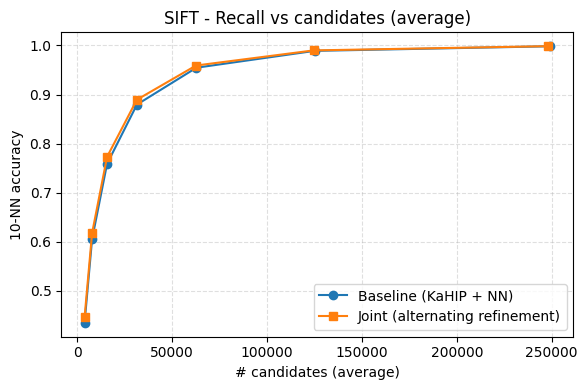

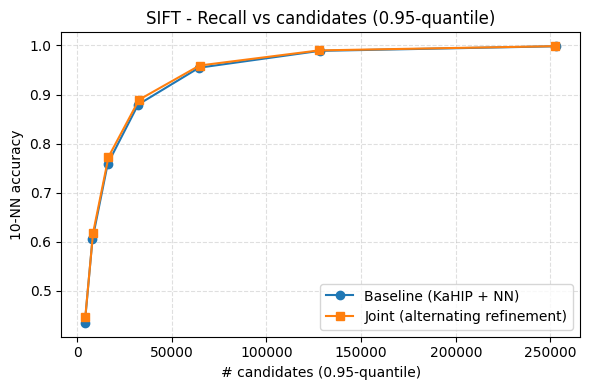

In [ ]:
def plot_recall_vs_candidates(baseline_results, refined_results, use_q95=False, title_suffix=""):
    """
    Plot 10-NN recall vs #candidates (avg or 0.95-quantile) for baseline vs refined.
    """
    if use_q95:
        cand_key = "q95_candidates"
        x_label = "# candidates (0.95-quantile)"
    else:
        cand_key = "avg_candidates"
        x_label = "# candidates (average)"

    # x-axis: #candidates; y-axis: avg recall
    x_base = np.array(baseline_results[cand_key])
    y_base = np.array(baseline_results["avg_recall"])
    x_ref  = np.array(refined_results[cand_key])
    y_ref  = np.array(refined_results["avg_recall"])

    plt.figure(figsize=(6,4))
    plt.plot(x_base, y_base, marker="o", label="Baseline (KaHIP + NN)")
    plt.plot(x_ref,  y_ref,  marker="s", label="Joint (alternating refinement)")

    plt.xlabel(x_label)
    plt.ylabel("10-NN accuracy")
    plt.title(f"SIFT - Recall vs candidates {title_suffix}")
    plt.grid(True, which="both", linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot using average #candidates (like left panels in the Neural LSH plots)
plot_recall_vs_candidates(baseline_results, refined_results, use_q95=False, title_suffix="(average)")

# Plot using 0.95-quantile #candidates (like right panels)
plot_recall_vs_candidates(baseline_results, refined_results, use_q95=True, title_suffix="(0.95-quantile)")


In [ ]:
import os
import math
import numpy as np
from typing import Optional, Tuple, Dict, List

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans


# ============================================
# A. Load SIFT
# ============================================

def read_fvecs(path: str) -> np.ndarray:
    a = np.fromfile(path, dtype='int32')
    if a.size == 0:
        raise ValueError(f"Empty fvecs file at {path}")
    d = a[0]
    return a.reshape(-1, d + 1)[:, 1:].astype('float32')


def read_ivecs(path: str) -> np.ndarray:
    a = np.fromfile(path, dtype='int32')
    if a.size == 0:
        raise ValueError(f"Empty ivecs file at {path}")
    d = a[0]
    return a.reshape(-1, d + 1)[:, 1:]


def load_sift_dataset(root: str = "./sift") -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    base_path = os.path.join(root, "sift_base.fvecs")
    query_path = os.path.join(root, "sift_query.fvecs")
    gt_path = os.path.join(root, "sift_groundtruth.ivecs")

    X = read_fvecs(base_path)
    Q = read_fvecs(query_path)
    GT = read_ivecs(gt_path)
    print(f"Loaded SIFT base: {X.shape}, queries: {Q.shape}, GT: {GT.shape}")
    return X, Q, GT


# ============================================
# B. Build k-NN graph
# ============================================

def build_knn_graph(
    X: np.ndarray,
    k: int = 16,
    metric: str = "euclidean",
    symmetrize: bool = True,
) -> np.ndarray:
    """
    Return edge_index as numpy array (E, 2) with int64 indices.
    """
    n, d = X.shape
    print(f"Building k-NN graph with n={n}, d={d}, k={k} ...")
    nbrs = NearestNeighbors(n_neighbors=k + 1, metric=metric)
    nbrs.fit(X)
    _, indices = nbrs.kneighbors(X)

    rows = []
    cols = []
    for i in range(n):
        for j in indices[i]:
            if j == i:
                continue
            rows.append(i)
            cols.append(j)

    edges = np.stack([rows, cols], axis=1)
    if symmetrize:
        rev = edges[:, [1, 0]]
        edges = np.concatenate([edges, rev], axis=0)
        edges = np.unique(edges, axis=0)

    print(f"k-NN graph has {edges.shape[0]} edges.")
    return edges.astype(np.int64)


# ============================================
# C. Classifier model
# ============================================

class MLPClassifier(nn.Module):
    def __init__(
        self,
        input_dim: int,
        num_bins: int,
        hidden_dims=(256, 256),
        dropout: float = 0.1,
    ):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            if dropout > 0.0:
                layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, num_bins))
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # logits
        return self.net(x)


# ============================================
# D. Init: balanced k-means partition
# ============================================

def init_balanced_kmeans(
    X: np.ndarray,
    num_bins: int,
    random_state: int = 0,
) -> np.ndarray:
    """
    1) Run k-means.
    2) Enforce approximate balance by greedily moving points from overfull to underfull bins.

    Returns:
        labels: (N,) int64 in [0, num_bins-1]
    """
    N = X.shape[0]
    print("Running k-means for initialization...")
    km = KMeans(n_clusters=num_bins, random_state=random_state, n_init=10)
    labels = km.fit_predict(X)  # (N,)

    # Target capacity per bin
    target = N // num_bins
    sizes = np.bincount(labels, minlength=num_bins)

    print("Initial cluster sizes:", sizes)

    # If highly imbalanced, reassign some points
    # Simple greedy: while any bin > target+1, move farthest points to underfull bins
    overfull_bins = [b for b in range(num_bins) if sizes[b] > target + 1]
    underfull_bins = [b for b in range(num_bins) if sizes[b] < target]

    if not overfull_bins and not underfull_bins:
        print("Clusters already roughly balanced.")
        return labels.astype(np.int64)

    # Precompute distances to centroids
    centroids = km.cluster_centers_
    # We only need approximate ordering, so we can do simple L2 distances
    def sqdist(a, b):
        return np.sum((a - b) ** 2, axis=1)

    for b in overfull_bins:
        while sizes[b] > target + 1 and len(underfull_bins) > 0:
            # Points currently in bin b
            idxs = np.where(labels == b)[0]
            # distances from these points to their centroid b
            dists = sqdist(X[idxs], centroids[b:b+1])
            # sort by distance descending: move farthest first
            order = np.argsort(-dists)

            moved_any = False
            for oid in order:
                i = idxs[oid]
                # pick a random underfull bin for now
                if not underfull_bins:
                    break
                ub = underfull_bins[0]
                labels[i] = ub
                sizes[b] -= 1
                sizes[ub] += 1
                moved_any = True

                if sizes[ub] >= target:
                    underfull_bins.pop(0)

                if sizes[b] <= target + 1:
                    break

            if not moved_any:
                break

    print("Balanced cluster sizes:", sizes)
    return labels.astype(np.int64)


# ============================================
# E. Classifier training for fixed labels
# ============================================

def train_classifier_epoch(
    model: MLPClassifier,
    X: np.ndarray,
    labels: np.ndarray,
    batch_size: int = 2048,
    device: str = "cuda" if torch.cuda.is_available() else "cpu",
    lr: float = 1e-3,
    num_epochs: int = 5,
) -> None:
    """
    Simple supervised training on (X, labels) with cross-entropy.
    """
    model.to(device)
    model.train()

    N, d = X.shape
    X_t = torch.from_numpy(X).float()
    y_t = torch.from_numpy(labels).long()

    dataset = torch.utils.data.TensorDataset(X_t, y_t)
    loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True, drop_last=False
    )

    opt = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, num_epochs + 1):
        total_loss = 0.0
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            opt.zero_grad()
            logits = model(xb)
            loss = F.cross_entropy(logits, yb)
            loss.backward()
            opt.step()
            total_loss += loss.item() * xb.size(0)
        print(f"  [Classifier epoch {epoch}/{num_epochs}] CE={total_loss / N:.4f}")


# ============================================
# F. Graph-aware label refinement with capacity
# ============================================

def refine_labels(
    X: np.ndarray,
    labels: np.ndarray,
    model: MLPClassifier,
    edge_index: np.ndarray,
    num_bins: int,
    lambda_classifier: float = 1.0,
    lambda_neighbor: float = 1.0,
    max_iter: int = 1,
    random_state: int = 0,
) -> np.ndarray:
    """
    Given current hard labels and classifier, refine labels to better respect:
      - classifier predictions (want high p(y_i | x_i))
      - neighbor agreement (want same label as neighbors)
      - approximate balance (via implicit capacity: we try not to overfill bins too much)

    This is a greedy local update heuristic:
      - iterate over nodes in random order,
      - for each node, evaluate a local score for a few candidate bins,
      - move if it improves the score and doesn't blow up bin size too badly.

    The capacity is enforced softly by discouraging bins that are already large,
    using a size-based penalty term.
    """
    N = X.shape[0]
    device = next(model.parameters()).device
    model.eval()

    # Precompute classifier logits/probs
    with torch.no_grad():
        X_t = torch.from_numpy(X).float().to(device)
        logits = model(X_t)              # (N, m)
        log_probs = F.log_softmax(logits, dim=-1).cpu().numpy()  # (N, m)

    # Build adjacency lists for quick neighbor lookup
    neighbors: List[List[int]] = [[] for _ in range(N)]
    for i, j in edge_index:
        neighbors[i].append(j)

    # Current bin sizes
    sizes = np.bincount(labels, minlength=num_bins)
    target = N / num_bins

    rng = np.random.default_rng(random_state)

    # Helper: local score for assigning node i to bin c
    # Lower is better.
    def local_score(i: int, c: int) -> float:
        # classifier term: -log p(c | x_i)
        cls_term = -log_probs[i, c]

        # neighbor agreement: penalize neighbors with different label
        neigh = neighbors[i]
        if len(neigh) > 0:
            same = np.sum(labels[neigh] == c)
            # we want more same-label neighbors, so use minus same_count
            neigh_term = -(same / max(len(neigh), 1))
        else:
            neigh_term = 0.0

        # capacity / balance penalty: bins too large get penalized
        # e.g., quadratic penalty on (size / target)
        size_ratio = sizes[c] / target
        cap_term = size_ratio ** 2

        return lambda_classifier * cls_term + lambda_neighbor * neigh_term + cap_term

    labels_new = labels.copy()

    for it in range(max_iter):
        print(f"  [Refine iter {it+1}/{max_iter}]")
        order = rng.permutation(N)
        num_changes = 0

        for i in order:
            old_c = labels_new[i]

            # Evaluate current score
            old_score = local_score(i, old_c)

            # Try a few candidate bins:
            #  - the current label,
            #  - the top-3 bins according to classifier log-probs,
            #  - the majority label of neighbors.
            candidates = {old_c}

            # Top-3 classifier bins
            top3 = np.argsort(-log_probs[i])[:3]
            candidates.update(top3.tolist())

            # Neighbor majority
            neigh = neighbors[i]
            if len(neigh) > 0:
                neigh_labels = labels_new[neigh]
                majority = np.bincount(neigh_labels, minlength=num_bins).argmax()
                candidates.add(int(majority))

            best_c = old_c
            best_score = old_score

            for c in candidates:
                if c == old_c:
                    continue
                s = local_score(i, c)
                if s < best_score:
                    best_score = s
                    best_c = c

            if best_c != old_c:
                # update sizes and label
                sizes[old_c] -= 1
                sizes[best_c] += 1
                labels_new[i] = best_c
                num_changes += 1

        print(f"    Changes this iter: {num_changes}, sizes: {sizes}")

        if num_changes == 0:
            break

    return labels_new.astype(np.int64)


# ============================================
# G. Simple evaluation: recall@10 vs bins probed
# ============================================

def l2_dist(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    diff = b - a[None, :]
    return np.sum(diff * diff, axis=1)


def build_bin_index_from_labels(labels: np.ndarray) -> Dict[int, np.ndarray]:
    bin_index: Dict[int, List[int]] = {}
    for i, c in enumerate(labels):
        bin_index.setdefault(int(c), []).append(i)
    return {b: np.array(idxs, dtype=np.int64) for b, idxs in bin_index.items()}


def multiprobe_candidates_from_labels(
    model: MLPClassifier,
    X_db: np.ndarray,
    q: np.ndarray,
    bin_index: Dict[int, np.ndarray],
    num_bins_to_probe: int,
    device: str = "cuda" if torch.cuda.is_available() else "cpu",
) -> np.ndarray:
    model.eval()
    q_t = torch.from_numpy(q[None, :]).float().to(device)
    with torch.no_grad():
        logits = model(q_t)
        probs = F.softmax(logits, dim=-1).cpu().numpy()[0]
    sorted_bins = np.argsort(-probs)
    chosen_bins = sorted_bins[:num_bins_to_probe]
    candidates = []
    for b in chosen_bins:
        if b in bin_index:
            candidates.extend(bin_index[b].tolist())
    return np.array(candidates, dtype=np.int64)


def evaluate_recall_sift(
    X: np.ndarray,
    Q: np.ndarray,
    GT: np.ndarray,
    model: MLPClassifier,
    labels: np.ndarray,
    num_bins_to_probe_list: List[int],
    topk: int = 10,
    max_queries: int = 1000,
) -> None:
    nq = min(len(Q), max_queries)
    print(f"Evaluating on {nq} queries...")

    bin_index = build_bin_index_from_labels(labels)

    results = {}
    for nb in num_bins_to_probe_list:
        recalls = []
        cand_counts = []
        for qi in range(nq):
            q = Q[qi]
            gt = GT[qi, :topk]

            cand_idx = multiprobe_candidates_from_labels(
                model, X, q, bin_index, nb
            )
            cand_counts.append(len(cand_idx))

            if len(cand_idx) == 0:
                recalls.append(0.0)
                continue

            dists = l2_dist(q, X[cand_idx])
            topk_local = np.argsort(dists)[:topk]
            retrieved = cand_idx[topk_local]

            inter = np.intersect1d(retrieved, gt)
            recalls.append(len(inter) / float(topk))

        recalls = np.array(recalls)
        cand_counts = np.array(cand_counts)

        results[nb] = {
            "recall_mean": float(recalls.mean()),
            "cand_mean": float(cand_counts.mean()),
            "cand_p95": float(np.percentile(cand_counts, 95)),
        }

    print("===== Recall@{} vs candidates =====".format(topk))
    for nb in num_bins_to_probe_list:
        r = results[nb]
        print(
            f"Bins={nb:3d} | recall={r['recall_mean']:.4f} "
            f"| avg_cands={r['cand_mean']:.1f} "
            f"| p95_cands={r['cand_p95']:.1f}"
        )


# ============================================
# H. Main: alternating optimization
# ============================================

if __name__ == "__main__":
    # 1. Load SIFT
    X, Q, GT = load_sift_dataset("./sift")

    # Dev subset
    N_base = 200_000
    N_query = 2000
    rng = np.random.default_rng(0)
    base_indices = rng.choice(len(X), size=N_base, replace=False)
    X_sub = X[base_indices]
    Q_sub = Q[:N_query]

    # Recompute GT for subset
    print("Recomputing ground truth for subset...")
    nbrs_gt = NearestNeighbors(n_neighbors=100, metric="euclidean")
    nbrs_gt.fit(X_sub)
    _, GT_sub = nbrs_gt.kneighbors(Q_sub)
    GT_sub = GT_sub.astype(np.int32)

    # 2. Build k-NN graph on X_sub
    edge_index = build_knn_graph(X_sub, k=16, metric="euclidean")

    # 3. Init hard labels via balanced k-means
    num_bins = 64
    labels = init_balanced_kmeans(X_sub, num_bins=num_bins, random_state=0)

    # 4. Initialize classifier
    d = X_sub.shape[1]
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = MLPClassifier(input_dim=d, num_bins=num_bins, hidden_dims=(256, 256), dropout=0.1)

    # 5. Alternating optimization
    num_outer_iters = 8
    for outer in range(1, num_outer_iters + 1):
        print(f"\n=== Outer iteration {outer}/{num_outer_iters} ===")
        # A) Train classifier on current labels
        train_classifier_epoch(
            model, X_sub, labels,
            batch_size=4096,
            device=device,
            lr=1e-3,
            num_epochs=5,
        )

        # B) Refine labels using classifier + graph
        labels = refine_labels(
            X_sub,
            labels,
            model,
            edge_index,
            num_bins=num_bins,
            lambda_classifier=1.0,
            lambda_neighbor=1.0,
            max_iter=3,
            random_state=outer,
        )

    # 6. Evaluate NNS
    num_bins_to_probe_list = [1, 2, 4, 8, 16, 32, 64]
    evaluate_recall_sift(
        X_sub, Q_sub, GT_sub,
        model,
        labels,
        num_bins_to_probe_list,
        topk=10,
        max_queries=N_query,
    )


Loaded SIFT base: (1000000, 128), queries: (10000, 128), GT: (10000, 100)
Recomputing ground truth for subset...
Building k-NN graph with n=200000, d=128, k=16 ...
k-NN graph has 5540030 edges.
Running k-means for initialization...
Initial cluster sizes: [ 2271  3584  3249  2213  2163  4289  2438  3324  2105  3423  3112  4195
  4382  3632  3325  2326  4241  3377  1909  4505  4500  2751  1733  1843
  4200  2831  3396  4644  2855  2486  2087  2085  2907  1814 11353  3066
  3151  2022  2113  3755  3165  1767  2343  3792  2428  2407  1965  2342
  3997  2412  2423  4609  3743  3075  3325  2289  2756  3635  4042  3636
  1983  3216  2572  2423]
Balanced cluster sizes: [3125 3126 3126 3125 3125 3126 3125 3126 3125 3126 3125 3126 3126 3126
 3126 3125 3126 3126 3125 3126 3126 3125 3125 3125 3126 3125 3126 3126
 3125 3125 3125 3125 3125 3125 3126 3125 3126 3125 3125 3126 3126 3125
 3125 3126 3125 3125 3125 3125 3126 3125 3125 3126 3126 3125 3126 3125
 3125 3126 3126 3126 3125 3126 3125 3096]

===

In [ ]:
!wget ftp://ftp.irisa.fr/local/texmex/corpus/sift.tar.gz
!tar -xvf sift.tar.gz


--2025-12-07 15:03:14--  ftp://ftp.irisa.fr/local/texmex/corpus/sift.tar.gz
           => ‘sift.tar.gz’
Resolving ftp.irisa.fr (ftp.irisa.fr)... 131.254.254.45, 2001:660:7303:254::45
Connecting to ftp.irisa.fr (ftp.irisa.fr)|131.254.254.45|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /local/texmex/corpus ... done.
==> SIZE sift.tar.gz ... 168280445
==> PASV ... done.    ==> RETR sift.tar.gz ... done.
Length: 168280445 (160M) (unauthoritative)

sift.tar.gz         100%[===================>] 160.48M  14.4MB/s    in 10s     

2025-12-07 15:03:27 (15.4 MB/s) - ‘sift.tar.gz’ saved [168280445]

sift/
sift/sift_base.fvecs
sift/sift_groundtruth.ivecs
sift/sift_learn.fvecs
sift/sift_query.fvecs
